## Model Definition

In [32]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 100
IMAGE_SIZE = 64
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "hands_64_noBG"

# --- DATASET ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # Scales to [0, 1]
    # Ensure alpha channel is preserved
])

# Custom dataset loader to handle RGBA images
class RGBAImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = Image.open(path).convert("RGBA")  # Ensure RGBA format
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

dataset = RGBAImageFolder(root=DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


### 4 Channel Generator / Discriminator

In [33]:
class DCGANGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(DCGANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 4, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64 — RGBA (was 3)
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z.view(z.size(0), z.size(1), 1, 1))
    
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),  # Change input channels from 3 to 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

### Training

In [34]:
# --- MODEL INITIALIZATION ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_discriminator = DCGANDiscriminator().to(DEVICE)

optimizer_G = torch.optim.Adam(dcgan_generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(dcgan_discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

#adversarial_loss = nn.BCELoss()
adversarial_loss = nn.MSELoss()  # Use MSELoss instead of BCELoss

# --- TRAINING ---
for epoch in range(EPOCHS):
    dcgan_generator.train()
    dcgan_discriminator.train()
    total_g_loss = 0
    total_d_loss = 0

    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        batch_size = batch.size(0)

        batch += 0.05 * torch.randn_like(batch) # Add Gaussian noise to real images

        # --- Train Discriminator ---
        real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)  # Real labels = 0.9
        fake_labels = torch.zeros(batch_size, 1, device=DEVICE)       # Fake labels = 0.0

        # Real images
        real_loss = adversarial_loss(dcgan_discriminator(batch).view(-1, 1), real_labels)

        # Fake images
        z = torch.randn(batch_size, LATENT_DIM).to(DEVICE)
        fake_images = dcgan_generator(z)
        fake_loss = adversarial_loss(dcgan_discriminator(fake_images.detach()).view(-1, 1), fake_labels)

        # Total discriminator loss
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        # Generator tries to fool the discriminator
        g_loss = adversarial_loss(dcgan_discriminator(fake_images).view(-1, 1), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Generator Loss: {total_g_loss/len(dataloader):.4f}, Discriminator Loss: {total_d_loss/len(dataloader):.4f}")

    # Save sample images every few epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            z = torch.randn(16, LATENT_DIM).to(DEVICE)
            sample = dcgan_generator(z).cpu()
            utils.save_image(sample, f"GAN_training/dcgan_noBG_sample_epoch{epoch+1}.png", nrow=4)

Epoch 1/100, Generator Loss: 0.7771, Discriminator Loss: 0.0202
Epoch 2/100, Generator Loss: 0.8100, Discriminator Loss: 0.0077
Epoch 3/100, Generator Loss: 0.8100, Discriminator Loss: 0.0025
Epoch 4/100, Generator Loss: 0.8100, Discriminator Loss: 0.0006
Epoch 5/100, Generator Loss: 0.8100, Discriminator Loss: 0.0002
Epoch 6/100, Generator Loss: 0.8100, Discriminator Loss: 0.0002
Epoch 7/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 8/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 9/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 10/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 11/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 12/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 13/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 14/100, Generator Loss: 0.8100, Discriminator Loss: 0.0001
Epoch 15/100, Generator Loss: 0.8100, Discriminator Loss: 0.0000
Epoch 16/100, Generator Loss: 0.81

In [35]:
# Save the generator and discriminator models after training
torch.save(dcgan_generator.state_dict(), "dcgan_noBG_generator_MSE_0100.pth")
torch.save(dcgan_discriminator.state_dict(), "dcgan_noBG_discriminator_MSE_0100.pth")

## Generation

#### Image Processing

In [40]:
from PIL import Image, ImageOps, ImageEnhance
import torch
import os

def process_image(image_path, output_path):
    """
    Process an image by replacing transparent pixels with white, 
    converting it to black and white, and increasing contrast.
    
    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the processed image.
    """
    # Open the image
    img = Image.open(image_path).convert("RGBA")

    # Replace transparent pixels with white
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # White background
    img = Image.alpha_composite(background, img)  # Combine with white background

    # Convert to grayscale (black and white)
    img = img.convert("L")

    # Increase contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)  # Adjust the factor as needed (e.g., 2.0 for higher contrast)

    # Save the processed image
    img.save(output_path)
    print(f"Processed image saved to {output_path}")

def process_generated_image(image_tensor):
    """
    Process a generated image tensor by replacing transparent pixels with white,
    converting it to black and white, and increasing contrast.
    
    Args:
        image_tensor (torch.Tensor): The generated image tensor (shape: [C, H, W]).
    
    Returns:
        Image: The processed PIL Image.
    """
    # Convert the tensor to a PIL image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HWC format
    #image = (image * 255).astype("uint8")  # Scale to [0, 255]
    img = Image.fromarray(image).convert("RGBA")  # Ensure RGBA format

    # Replace transparent pixels with white
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # White background
    img = Image.alpha_composite(background, img)  # Combine with white background

    # Convert to grayscale (black and white)
    img = img.convert("L")

    # Increase contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)  # Adjust the factor as needed (e.g., 2.0 for higher contrast)

    return img

def process_images_in_folder(folder_path):
    """
    Process all image files in a folder by replacing transparent pixels with white,
    converting them to black and white, and increasing contrast. Saves the processed
    images with "_processed" added to their filenames.
    
    Args:
        folder_path (str): Path to the folder containing the images.
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return


def process_images_in_folder(folder_path, output_folder, suffix="_processed", replace_transparent=True):
    """
    Process all image files in a folder by optionally replacing transparent pixels with white,
    converting them to black and white, and increasing contrast. Saves the processed
    images in a specified output folder with a customizable suffix added to their filenames.
    
    Args:
        folder_path (str): Path to the folder containing the images.
        output_folder (str): Path to the folder where processed images will be saved.
        suffix (str): Suffix to add to the processed file names (default: "_processed").
        replace_transparent (bool): Whether to replace transparent pixels with white (default: True).
    """
    # Ensure the input folder exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each file in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is an image (e.g., PNG, JPG)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Open the image
                img = Image.open(file_path).convert("RGBA")

                # Optionally replace transparent pixels with white
                if not replace_transparent:
                # Split the image into RGB and alpha channels
                    r, g, b, alpha = img.split()

                    # Merge RGB channels into a single image
                    rgb = Image.merge("RGB", (r, g, b))

                    # Darken the RGB channels by reducing brightness
                    brightness_enhancer = ImageEnhance.Brightness(rgb)
                    rgb_darker = brightness_enhancer.enhance(0.4)  # Reduce brightness (0.5 = 50% darker)

                    # Convert the darkened RGB image to grayscale
                    grayscale = rgb_darker.convert("L")

                    # Merge the grayscale image back with the alpha channel
                    img = Image.merge("RGBA", (grayscale, grayscale, grayscale, alpha))

                else:
                    # Replace transparent pixels with white
                    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # White background
                    img = Image.alpha_composite(background, img)  # Combine with white background

                    # Convert the entire image to grayscale
                    img = img.convert("L")


                # Increase contrast
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(3.0)  # Adjust the factor as needed

                # Save the processed image in the output folder with the custom suffix
                new_filename = f"{os.path.splitext(filename)[0]}{suffix}{os.path.splitext(filename)[1]}"
                new_file_path = os.path.join(output_folder, new_filename)
                img.save(new_file_path)
                print(f"Processed and saved: {new_file_path}")
            except Exception as e:
                print(f"Failed to process file '{filename}': {e}")
        else:
            print(f"Skipped non-image file: {filename}")



# Example usage:
#process_image("latent_variations_multiple_dims.png", "processed_image_02.png")
process_images_in_folder("tsne_images_MSE", "tsne_images_MSE_processed", suffix="", replace_transparent=False)




Processed and saved: tsne_images_MSE_processed/image_408.png
Processed and saved: tsne_images_MSE_processed/image_420.png
Processed and saved: tsne_images_MSE_processed/image_346.png
Processed and saved: tsne_images_MSE_processed/image_352.png
Processed and saved: tsne_images_MSE_processed/image_434.png
Processed and saved: tsne_images_MSE_processed/image_385.png
Processed and saved: tsne_images_MSE_processed/image_391.png
Processed and saved: tsne_images_MSE_processed/image_178.png
Processed and saved: tsne_images_MSE_processed/image_144.png
Processed and saved: tsne_images_MSE_processed/image_622.png
Processed and saved: tsne_images_MSE_processed/image_636.png
Processed and saved: tsne_images_MSE_processed/image_150.png
Processed and saved: tsne_images_MSE_processed/image_805.png
Processed and saved: tsne_images_MSE_processed/image_811.png
Processed and saved: tsne_images_MSE_processed/image_187.png
Processed and saved: tsne_images_MSE_processed/image_839.png
Processed and saved: tsn

### Testing Sensor Input interrupt

In [42]:
!pip install websockets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Image generation

In [25]:
import torch
from torchvision.utils import save_image
import numpy as np

# --- Load the Trained Generator ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_generator.load_state_dict(torch.load("dcgan_noBG_generator_030.pth"))
dcgan_generator.eval()  # Set to evaluation mode

import os
from torchvision.utils import save_image

def generate_images_along_latent_dimensions(generator, latent_dim, num_variations=10, fixed_dim=0, save_individual=False, output_folder="generated_images"):
    """
    Generate images by varying a specific latent dimension.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_variations: Number of variations along the latent dimension.
        fixed_dim: The index of the latent dimension to vary.
        save_individual (bool): Whether to save individual images instead of combining them.
        output_folder (str): Folder where individual images will be saved (if save_individual=True).
    """
    base_z = torch.randn(1, latent_dim).to(DEVICE)  # Base latent vector
    variations = torch.linspace(-3, 3, num_variations).to(DEVICE)  # Range of values for the dimension

    generated_images = []
    
    # Create the output folder if saving individual images
    if save_individual:
        os.makedirs(output_folder, exist_ok=True)

    for i, value in enumerate(variations):
        z = base_z.clone()  # Clone the base latent vector
        z[0, fixed_dim] = value  # Modify the specific latent dimension
        with torch.no_grad():
            generated_image = generator(z).cpu()
            generated_images.append(generated_image)

            # Save individual images if the option is enabled
            if save_individual:
                image_path = os.path.join(output_folder, f"image_{i:03d}.png")
                save_image(generated_image, image_path, normalize=True)
                print(f"Saved: {image_path}")

    # Combine all generated images into a grid if not saving individually
    if not save_individual:
        combined_image_path = os.path.join(output_folder, "latent_variations.png")
        os.makedirs(output_folder, exist_ok=True)  # Ensure the folder exists
        generated_images = torch.cat(generated_images, dim=0)
        save_image(generated_images, combined_image_path, nrow=num_variations, normalize=True)
        print(f"Combined image saved as '{combined_image_path}'.")


def generate_images_varying_multiple_dimensions(generator, latent_dim, num_variations=10, dims_to_vary=[0, 1]):
    base_z = torch.randn(1, latent_dim).to(DEVICE)
    variations = torch.linspace(-3, 3, num_variations).to(DEVICE)

    generated_images = []
    for value in variations:
        z = base_z.clone()
        for dim in dims_to_vary:
            z[0, dim] = value  # Modify multiple dimensions
        with torch.no_grad():
            generated_image = dcgan_generator(z).cpu()
            generated_images.append(generated_image)

    generated_images = torch.cat(generated_images, dim=0)
    save_image(generated_images, "latent_variations_multiple_dims.png", nrow=num_variations, normalize=True)
    print("Generated images saved as 'latent_variations_multiple_dims.png'.")

def interpolate_latent_space(generator, latent_dim, num_interpolations=10, save_individual=False, output_folder="interpolated_images"):
    """
    Interpolate between two random latent vectors and generate images along the interpolation path.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_interpolations: Number of interpolation steps.
        save_individual (bool): Whether to save individual images instead of combining them.
        output_folder (str): Folder where individual images will be saved (if save_individual=True).
    """
    # Generate two random latent vectors
    z_start = torch.randn(1, latent_dim).to(DEVICE)
    z_end = torch.randn(1, latent_dim).to(DEVICE)

    # Interpolate between the two latent vectors
    interpolations = torch.linspace(0, 1, num_interpolations).to(DEVICE)
    generated_images = []

    # Create the output folder if saving individual images
    if save_individual:
        os.makedirs(output_folder, exist_ok=True)

    for i, alpha in enumerate(interpolations):
        z = (1 - alpha) * z_start + alpha * z_end  # Linear interpolation
        with torch.no_grad():
            generated_image = generator(z).cpu()
            generated_images.append(generated_image)

            # Save individual images if the option is enabled
            if save_individual:
                image_path = os.path.join(output_folder, f"interpolated_{i:03d}.png")
                save_image(generated_image, image_path, normalize=True)
                print(f"Saved: {image_path}")

    # Combine all generated images into a grid if not saving individually
    if not save_individual:
        combined_image_path = os.path.join(output_folder, "interpolated_grid.png")
        os.makedirs(output_folder, exist_ok=True)  # Ensure the folder exists
        generated_images = torch.cat(generated_images, dim=0)
        save_image(generated_images, combined_image_path, nrow=num_interpolations, normalize=True)
        print(f"Combined image saved as '{combined_image_path}'.")


#generate_images_varying_multiple_dimensions(dcgan_generator, latent_dim=LATENT_DIM, num_variations=10, dims_to_vary=[0, 1])

#generate_images_along_latent_dimensions(dcgan_generator, latent_dim=LATENT_DIM, num_variations=50, fixed_dim=4, save_individual=True, output_folder="generated_images")

interpolate_latent_space(dcgan_generator, latent_dim=LATENT_DIM, num_interpolations=50, save_individual=True, output_folder="interpolated_images")


Saved: interpolated_images/interpolated_000.png
Saved: interpolated_images/interpolated_001.png
Saved: interpolated_images/interpolated_002.png
Saved: interpolated_images/interpolated_003.png
Saved: interpolated_images/interpolated_004.png
Saved: interpolated_images/interpolated_005.png
Saved: interpolated_images/interpolated_006.png
Saved: interpolated_images/interpolated_007.png
Saved: interpolated_images/interpolated_008.png
Saved: interpolated_images/interpolated_009.png
Saved: interpolated_images/interpolated_010.png
Saved: interpolated_images/interpolated_011.png
Saved: interpolated_images/interpolated_012.png
Saved: interpolated_images/interpolated_013.png
Saved: interpolated_images/interpolated_014.png
Saved: interpolated_images/interpolated_015.png
Saved: interpolated_images/interpolated_016.png
Saved: interpolated_images/interpolated_017.png
Saved: interpolated_images/interpolated_018.png
Saved: interpolated_images/interpolated_019.png
Saved: interpolated_images/interpolated_

### Create GIF

In [38]:
import torch
from torchvision.utils import save_image
from PIL import Image
import os

# --- Generate a GIF by Interpolating in Latent Space ---
def generate_latent_space_gif(generator, latent_dim, num_frames=30, output_gif="latent_space.gif"):
    """
    Generate a GIF by interpolating between two random latent vectors.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_frames: Number of frames in the GIF.
        output_gif: Name of the output GIF file.
    """
    # Create two random latent vectors
    z_start = torch.randn(1, latent_dim).to(DEVICE)
    z_end = torch.randn(1, latent_dim).to(DEVICE)

    # Interpolate between the two latent vectors
    interpolations = torch.linspace(0, 1, num_frames).to(DEVICE)
    frames = []

    for alpha in interpolations:
        z = (1 - alpha) * z_start + alpha * z_end  # Linear interpolation
        with torch.no_grad():
            generated_image = dcgan_generator(z).cpu()
            generated_image = (generated_image + 1) / 2  # Normalize to [0, 1]
            generated_image = generated_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert to HWC format
            generated_image = (generated_image * 255).astype("uint8")  # Convert to uint8
            #processed_image = process_generated_image(generated_image)  # Process the image
            #frames.append(processed_image)
            frames.append(Image.fromarray(generated_image))

    # Save frames as a GIF
    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=100,  # Duration of each frame in milliseconds
        loop=0  # Infinite loop
    )
    print(f"GIF saved as '{output_gif}'.")

# --- Generate a GIF by Interpolating Along a Specific Axis ---
def generate_latent_space_gif_along_axis(generator, latent_dim, axis=0, num_frames=30, output_gif="latent_space_axis.gif"):
    """
    Generate a GIF by interpolating along a specific axis in the latent space.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        axis: The index of the latent dimension to vary.
        num_frames: Number of frames in the GIF.
        output_gif: Name of the output GIF file.
    """
    # Create a base latent vector
    z_base = torch.randn(1, latent_dim).to(DEVICE)

    # Interpolate along the specified axis
    variations = torch.linspace(-3, 3, num_frames).to(DEVICE)
    frames = []

    for value in variations:
        z = z_base.clone()  # Clone the base latent vector
        z[0, axis] = value  # Modify the specific axis
        with torch.no_grad():
            generated_image = generator(z).cpu()
            generated_image = (generated_image + 1) / 2  # Normalize to [0, 1]
            generated_image = generated_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert to HWC format
            generated_image = (generated_image * 255).astype("uint8")  # Convert to uint8
            frames.append(Image.fromarray(generated_image))

    # Save frames as a GIF
    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=100,  # Duration of each frame in milliseconds
        loop=0  # Infinite loop
    )
    print(f"GIF saved as '{output_gif}'.")


def generate_latent_space_gif_with_processing(generator, latent_dim, num_frames=30, output_gif="latent_space_processed.gif"):
    """
    Generate a GIF by interpolating between two random latent vectors and processing the images.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_frames: Number of frames in the GIF.
        output_gif: Name of the output GIF file.
    """
    # Create two random latent vectors
    z_start = torch.randn(1, latent_dim).to(DEVICE)
    z_end = torch.randn(1, latent_dim).to(DEVICE)

    # Interpolate between the two latent vectors
    interpolations = torch.linspace(0, 1, num_frames).to(DEVICE)
    frames = []
    frames_unprocessed = []
    output_gif_unprocessed = "unprocessed_" + output_gif

    for alpha in interpolations:
        z = (1 - alpha) * z_start + alpha * z_end  # Linear interpolation
        with torch.no_grad():
            generated_image = generator(z).cpu().squeeze(0)  # Shape: [C, H, W]
            processed_image = process_generated_image(generated_image)  # Pass the tensor directly
            frames.append(processed_image)
            

    # Save frames as a GIF
    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=100,  # Duration of each frame in milliseconds
        loop=0  # Infinite loop
    )

    
    print(f"Processed GIF saved as '{output_gif}'.")

# --- Example Usage ---
# --- Example Usage ---
generate_latent_space_gif_with_processing(dcgan_generator, latent_dim=LATENT_DIM, num_frames=60, output_gif="latent_space_processed_01.gif")
#generate_latent_space_gif(dcgan_generator, latent_dim=LATENT_DIM, num_frames=60, output_gif="latent_space.gif")
#generate_latent_space_gif_along_axis(dcgan_generator, latent_dim=LATENT_DIM, axis=40, num_frames=60, output_gif="latent_space_axis.gif")

Processed GIF saved as 'latent_space_processed_01.gif'.


## Model Vizualisation

In [16]:
!pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl (11.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 26.8 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### old versions

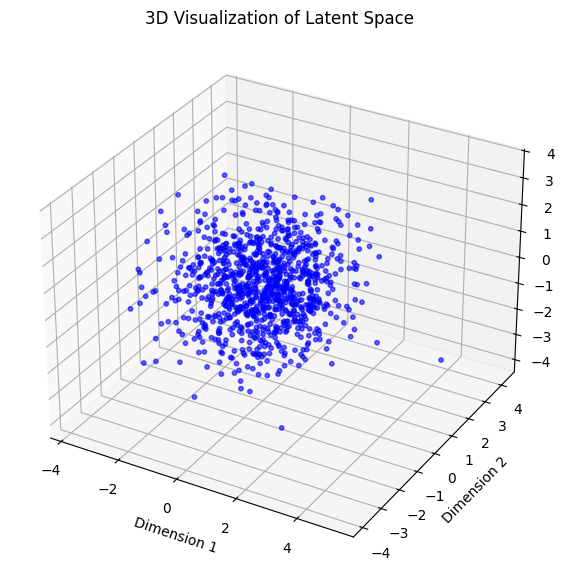

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch

# --- Generate Latent Vectors ---
num_samples = 1000  # Number of latent vectors to sample
z = torch.randn(num_samples, LATENT_DIM).to(DEVICE)  # Random latent vectors

# Assuming `z_real` and `z_fake` are latent vectors for real and generated images
z_real = torch.randn(500, LATENT_DIM).to(DEVICE)  # Latent vectors for real images
z_fake = torch.randn(500, LATENT_DIM).to(DEVICE)  # Latent vectors for generated images

# Combine real and fake latent vectors
z_combined = torch.cat([z_real, z_fake], dim=0)

# If you want to extract latent vectors from real images:
# latent_vectors = []
# for batch, _ in dataloader:
#     batch = batch.to(DEVICE)
#     with torch.no_grad():
#         latent_vectors.append(dcgan_generator.encoder(batch))  # Assuming encoder exists
# z = torch.cat(latent_vectors, dim=0)

# --- Dimensionality Reduction ---
if LATENT_DIM > 3:
    # Use PCA or t-SNE to reduce to 3 dimensions
    z_reduced = PCA(n_components=3).fit_transform(z.cpu().numpy())
    # Alternatively, use t-SNE for non-linear dimensionality reduction
    # z_reduced = TSNE(n_components=3).fit_transform(z.cpu().numpy())
else:
    z_reduced = z.cpu().numpy()

# Assign colors: blue for real, red for fake
colors = ['blue'] * len(z_real) + ['red'] * len(z_fake)

# --- 3D Visualization ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of latent vectors
ax.scatter(z_reduced[:, 0], z_reduced[:, 1], z_reduced[:, 2], c='blue', alpha=0.6, s=10)

# Add labels and title
ax.set_title("3D Visualization of Latent Space")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()

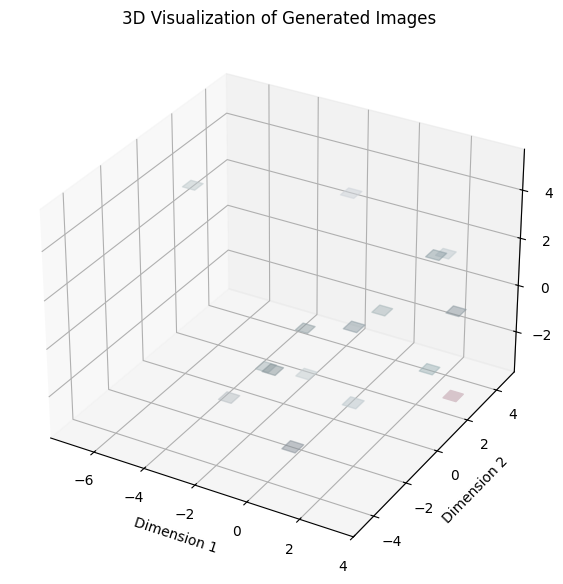

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np

# --- Generate Latent Vectors ---
num_samples = 16  # Number of latent vectors to sample
z = torch.randn(num_samples, LATENT_DIM).to(DEVICE)  # Random latent vectors

# --- Dimensionality Reduction ---
if LATENT_DIM > 3:
    z_reduced = PCA(n_components=3).fit_transform(z.cpu().numpy())
else:
    z_reduced = z.cpu().numpy()

# --- Generate Images ---
with torch.no_grad():
    generated_images = dcgan_generator(z).cpu()  # Shape: [16, 3, 64, 64]

# Normalize images for display
generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]

# --- 3D Visualization with Images ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each image as a plane in 3D space
for i, (x, y, z) in enumerate(z_reduced):
    img = generated_images[i].permute(1, 2, 0).numpy()  # Convert to HWC format
    img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]

    # Create a plane for the image
    x_offset, y_offset, z_offset = x, y, z
    x_plane = np.array([[x_offset, x_offset], [x_offset + 0.5, x_offset + 0.5]])
    y_plane = np.array([[y_offset, y_offset + 0.5], [y_offset, y_offset + 0.5]])
    z_plane = np.array([[z_offset, z_offset], [z_offset, z_offset]])

    # Map the image onto the plane
    ax.plot_surface(x_plane, y_plane, z_plane, rstride=1, cstride=1, facecolors=img, shade=False)

# Add labels and title
ax.set_title("3D Visualization of Generated Images")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()

## TSNE and PCA dim reduction

In [38]:
import os
import torch
from torchvision.utils import save_image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import base64
from PIL import Image
import io
import json

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # Enable CPU fallback for unsupported MPS operations


# --- Load the Trained Generator ---
dcgan_generator = DCGANGenerator(latent_dim=LATENT_DIM).to(DEVICE)
dcgan_generator.load_state_dict(torch.load("dcgan_noBG_generator_MSE_0100.pth"))
dcgan_generator.eval()  # Set to evaluation mode

def generate_tsne_visualization(generator, latent_dim, num_samples=100, output_folder="tsne_images", use_base64=False, output_json="output.json"):
    """
    Generate images and visualize them in 3D space using t-SNE reduction.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_samples: Number of latent vectors to generate.
        output_folder (str): Folder where generated images will be saved.
        use_base64 (bool): Whether to encode images as base64 strings instead of saving them as files.
        output_json (str): Path to save the output JSON file.
    
    Returns:
        list: A list of dictionaries containing 3D coordinates and image URLs or base64 strings.
    """
    # Create the output folder if saving images
    if not use_base64:
        os.makedirs(output_folder, exist_ok=True)

    # Step 1: Generate latent vectors
    z = torch.randn(num_samples, latent_dim).to(DEVICE)

    # Step 2: Reduce latent vectors to 3D using t-SNE
    z_reduced = TSNE(n_components=3).fit_transform(z.cpu().numpy())

    # Step 3: Generate images and prepare output
    output = []
    for i, latent_vector in enumerate(z):
        with torch.no_grad():
            generated_image = generator(latent_vector.unsqueeze(0)).cpu()  # Shape: [1, C, H, W]
            generated_image = (generated_image + 1) / 2  # Normalize to [0, 1]

            if use_base64:
                # Convert image to base64
                buffer = io.BytesIO()
                save_image(generated_image, buffer, format="PNG", normalize=True)
                buffer.seek(0)
                base64_image = f"data:image/png;base64,{base64.b64encode(buffer.read()).decode('utf-8')}"
                output.append({
                    "position": z_reduced[i].tolist(),
                    "imageUrl": base64_image
                })
            else:
                # Save image to file
                image_path = os.path.join(output_folder, f"image_{i:03d}.png")
                save_image(generated_image, image_path, normalize=True)
                output.append({
                    "position": z_reduced[i].tolist(),
                    "imageUrl": image_path
                })

    # Save the output as a JSON file
    with open(output_json, "w") as json_file:
        json.dump(output, json_file, indent=4)
    print(f"Output saved as JSON: {output_json}")

    return output


def generate_dimensionality_reduction_visualization(
    generator, latent_dim, num_samples=100, reduction_method="tsne", output_folder="reduced_images", use_base64=False, output_json="output.json"
):
    """
    Generate images and visualize them in 3D space using t-SNE or PCA reduction.
    
    Args:
        generator: The trained generator model.
        latent_dim: The size of the latent space.
        num_samples: Number of latent vectors to generate.
        reduction_method (str): Dimensionality reduction method ("tsne" or "pca").
        output_folder (str): Folder where generated images will be saved.
        use_base64 (bool): Whether to encode images as base64 strings instead of saving them as files.
        output_json (str): Path to save the output JSON file.
    
    Returns:
        list: A list of dictionaries containing 3D coordinates and image URLs or base64 strings.
    """

    generator = generator.to("cpu")

    # Create the output folder if saving images
    if not use_base64:
        os.makedirs(output_folder, exist_ok=True)

    # Step 1: Generate latent vectors
    z = torch.randn(num_samples, latent_dim).to("cpu")  # Use CPU for compatibility with sklearn

    # Step 2: Apply dimensionality reduction
    if reduction_method.lower() == "tsne":
        print("Using t-SNE for dimensionality reduction...")
        z_reduced = TSNE(n_components=3).fit_transform(z.numpy())
    elif reduction_method.lower() == "pca":
        print("Using PCA for dimensionality reduction...")
        z_reduced = PCA(n_components=3).fit_transform(z.numpy())
    else:
        raise ValueError("Invalid reduction method. Choose 'tsne' or 'pca'.")

    # Step 3: Generate images and prepare output
    output = []
    for i, latent_vector in enumerate(z):
        with torch.no_grad():
            generated_image = generator(latent_vector.unsqueeze(0)).cpu()  # Shape: [1, C, H, W]
            generated_image = (generated_image + 1) / 2  # Normalize to [0, 1]

            if use_base64:
                # Convert image to base64
                import io
                import base64
                buffer = io.BytesIO()
                save_image(generated_image, buffer, format="PNG", normalize=True)
                buffer.seek(0)
                base64_image = f"data:image/png;base64,{base64.b64encode(buffer.read()).decode('utf-8')}"
                output.append({
                    "position": z_reduced[i].tolist(),
                    "imageUrl": base64_image
                })
            else:
                # Save image to file
                image_path = os.path.join(output_folder, f"image_{i:03d}.png")
                save_image(generated_image, image_path, normalize=True)
                output.append({
                    "position": z_reduced[i].tolist(),
                    "imageUrl": image_path
                })

    # Save the output as a JSON file
    with open(output_json, "w") as json_file:
        json.dump(output, json_file, indent=4)
    print(f"Output saved as JSON: {output_json}")

    return output

"""
# Example Usage
output = generate_tsne_visualization(
    dcgan_generator, 
    latent_dim=LATENT_DIM, 
    num_samples=1000, 
    output_folder="tsne_images", 
    use_base64=False, 
    output_json="tsne_output.json"
)"""

# Example Usage with PCA
output = generate_dimensionality_reduction_visualization(
    dcgan_generator, 
    latent_dim=LATENT_DIM, 
    num_samples=1000, 
    reduction_method="pca", 
    output_folder="pca_images_MSE", 
    use_base64=False, 
    output_json="pca_output_MSE.json"
)

Using PCA for dimensionality reduction...
Output saved as JSON: pca_output_MSE.json
